In [1]:
import os
import numpy as np
from numpy.random import default_rng
from pyfitit.ihs import ihs

import random
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# скорость белок задаютсся в мкл/сек и а на выходе мкл/мин
v1_s = 0.15
v1_e = 20
v1_d = 0.005
# скорость осадитель
v2_s = 0.15
v2_e = 20
v2_d = 0.005
# скорость разбавитель
v3_s = 0.15
v3_e = 20
v3_d = 0.005
# объем выдавливаемой смеси, мкл
volume = 200
# концентрации реагентов в шприцах
c1_def = 120
c2_def = 60
c3_def = 0
# области вариации концентраций в капле
c1_s = 0
c1_e = 60

c2_s = 0
c2_e = 30

In [7]:
def c_to_v(c_b, c_o):
    capa = (c1_def / c2_def) * c_o / c_b
    #    print(capa)
    # рассчет всех возможных комбинаций скоростей
    x = []
    for v3 in np.arange(v3_s, v3_e, v3_d):
        v_b = c_b * v3
        v_b /= c1_def - c_b * (1 + capa)
        v_o = capa * v_b
        # if -0.01<v_b-round(v_b,2)<0.01 and -0.001<v_o-round(v_o,2)<0.01:
        x.append((v_b, v_o, v3))
        # break
    # выбор тех что наиболее близки к округленному значению
    a = []
    for i in range(len(x)):
        if (
            -0.01 < x[i][0] - round(x[i][0], 3) < 0.01
            and -0.01 < x[i][1] - round(x[i][1], 3) < 0.01
        ):
            if x[i][0] > v1_s and x[i][2] > v2_s:
                a.append(x[i])
    b = []
    # выбор тех кто лежат в пределе 10-20 секунд выкапывания
    for i in range(len(a)):
        sum = a[i][0] + a[i][1] + a[i][2]
        time = volume / (sum)
        if time > 2:
            b.append((a[i][0] * 60, a[i][1] * 60, a[i][2] * 60, time))
            break
    return b


# b[0],b[1],b[2],b[3]

In [8]:
print(c_to_v(20, 24))

[(9.000000000000005, 21.60000000000001, 23.400000000000013, 222.22222222222211)]


для фикса

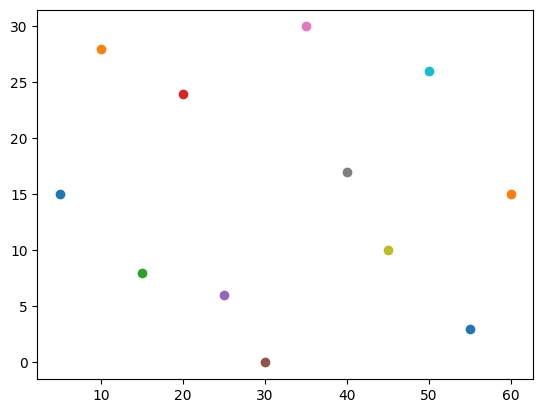

In [9]:
mas = [
    [5, 15],
    [10, 28],
    [15, 8],
    [20, 24],
    [25, 6],
    [30, 0],
    [35, 30],
    [40, 17],
    [45, 10],
    [50, 26],
    [55, 3],
    [60, 15],
]
for i in range(len(mas)):
    plt.scatter(mas[i][0], mas[i][1])

In [10]:
res = c_to_v(mas[6][0], mas[6][1])
print(res)

[(13.02, 22.32, 9.3, 268.81720430107526)]


для рандома ihs

22.25


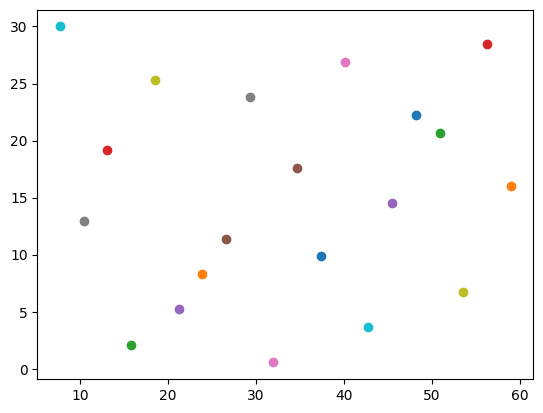

In [13]:
n = 20
bounds = [(5, 59), (-1, 30)]
res = ihs(2, n, seed=random.seed())
samples = []
# x4 = (0.3 - 0.6) flow
# x1 = (0 - 0.9)(flow - x3 - x4)
# x2 = flow - x3 - x4 - x1
# x3 = (0.1 - 0.9)(flow - x4)
for row in res:
    r = []
    for i, interval in zip(range(len(row)), bounds):
        r.append(interval[0] + (row[i] * 1.0 / n) * (interval[1] - interval[0]))
    samples.append(r)
real_values = []

for s in samples:
    x1 = round(s[0], 6)
    x3 = round(s[1], 6)
    real_values.append([x1, x3])
df = pd.DataFrame(real_values)
# df = df.round(1)
# plt.scatter(df[0].values, df[2].values)
mas = df.values.tolist()
print(df[1][0])
for i in range(len(df)):
    plt.scatter(df[0][i], df[1][i])

In [14]:
res = []
for i in range(len(mas)):
    t = c_to_v(mas[i][0], mas[i][1])
    print(t)
    if t != []:
        res.append(
            (
                mas[i][0],
                mas[i][1],
                t[0][0],
                t[0][1],
                t[0][2],
                t[0][3],
                t[0][0] + t[0][1] + t[0][2],
            )
        )

[(16.419780219780222, 15.159340659340659, 9.3, 293.5483870967742)]
[(9.018867924528307, 6.264150943396231, 30.00000000000002, 264.99999999999983)]
[(9.006000000000007, 2.3940000000000015, 57.00000000000004, 175.43859649122794)]
[(76.99852941176458, 77.8191176470587, 9.3, 73.1182795698926)]
[(9.065158371040729, 4.447058823529415, 37.800000000000026, 233.86243386243373)]
[(9.042492917847033, 7.750708215297456, 24.000000000000014, 294.16666666666646)]
[(9.058688147295747, 0.3113924050632913, 24.600000000000016, 353.25203252032503)]
[(9.020788530465955, 22.465232974910403, 72.60000000000005, 115.28925619834703)]
[(9.423062381852553, 2.373345935727788, 9.3, 568.8172043010752)]
[(9.000858369098715, 1.5351931330472106, 14.700000000000005, 475.51020408163254)]
[(9.0972972972973, 4.791891891891893, 15.300000000000008, 411.111111111111)]
[(18.986159169550167, 10.329757785467123, 9.3, 310.75268817204307)]
[(17.08916967509024, 13.899638989169665, 9.3, 297.84946236559153)]
[(9.05160349854228, 26.46

In [15]:
df = pd.DataFrame(res)

df.to_excel("20 точек ihs.xlsx", index=False)